> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

Investigate The Dataset of Kaggle (TMDb movie data!)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected/downloaded for analysis. Read through the description available on the homepage-links present [here](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True). List all column names in each table, and their significance. In case of multiple tables, describe the relationship between tables. 


### Question(s) for Analysis
>**Tip**: Clearly state one or more questions that you plan on exploring over the course of the report. You will address these questions in the **data analysis** and **conclusion** sections. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

> **Tip**: Once you start coding, use NumPy arrays, Pandas Series, and DataFrames where appropriate rather than Python lists and dictionaries. Also, **use good coding practices**, such as, define and use functions to avoid repetitive code. Use appropriate comments within the code cells, explanation in the mark-down cells, and meaningful variable names. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

In [2]:
#uplooad csv file using pandas 
df = pd.read_csv("tmdb-movies.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [3]:
#data set 
df

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.3,2015,1.747999e+08,1.385749e+09
5,281957,tt1663202,9.110700,135000000,532950503,The Revenant,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,http://www.foxmovies.com/movies/the-revenant,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,"(n. One who has returned, as if from the dead.)",...,"In the 1820s, a frontiersman, Hugh Glass, sets...",156,Western|Drama|Adventure|Thriller,Regency Enterprises|Appian Way|CatchPlay|Anony...,12/25/2015,3929,7.2,2015,1.241999e+08,4.903142e+08
6,87101,tt1340138,8.654359,155000000,440603537,Terminator Genisys,Arnold Schwarzenegger|Jason Clarke|Emilia Clar...,http://www.terminatormovie.com/,Alan Taylor,Reset the future,...,"The year is 2029. John Connor, leader of the r...",125,Science Fiction|Action|Thriller|Adventure,Paramount Pictures|Skydance Productions,6/23/2015,2598,5.8,2015,1.425999e+08,4.053551e+08
7,286217,tt3659388,7.667400,108000000,595380321,The Martian,Matt Damon|Jessica Chastain|Kristen Wiig|Jeff ...,http://www.foxmovies.com/movies/the-martian,Ridley Scott,Bring Him Home,...,"During a manned mission to Mars, Astronaut Mar...",141,Drama|Adventure|Science Fiction,Twentieth Century Fox Film Corporation|Scott F...,9/30/2015,4572,7.6,2015,9.935996e+07,5.477497e+08
8,211672,tt2293640,7.404165,74000000,1156730962,Minions,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,http://www.minionsmovie.com/,Kyle Balda|Pierre Coffin,"Before Gru, they had a history of bad bosses",...,"Minions Stuart, Kevin and Bob are recruited by...",91,Family|Animation|Adventure|Comedy,Universal Pictures|Illumination Entertainment,6/17/2015,2893,6.5,2015,6.807997e+07,1.064192e+09
9,150540,tt2096673,6.326804,175000000,853708609,Inside Out,Amy Poehler|Phyllis Smith|Richard Kind|Bill Ha...,http://movies.disney.com/inside-out,Pete Docter,Meet the little voices inside your head.,...,"Growing up can be a bumpy road, and it's no ex...",94,Comedy|Animation|Family,Walt Disney Pictures|Pixar Animation S

In [4]:
#find duplicates in dataset
df.duplicated().sum()

1

In [5]:
#after finding one duplictation we will show it to remove
df[df.duplicated()]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
2090,42194,tt0411951,0.59643,30000000,967000,TEKKEN,Jon Foo|Kelly Overton|Cary-Hiroyuki Tagawa|Ian...,NaN,Dwight H. Little,Survival is no game,...,"In the year of 2039, after World Wars destroy ...",92,Crime|Drama|Action|Thriller|Science Fiction,Namco|Light Song Films,3/20/2010,110,5.0,2010,30000000.0,967000.0


In [6]:
#drop duplicated row 
df.drop([2090] , axis = 0 , inplace = True)

In [7]:
#making sure it was dropped
df[df.duplicated()]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj



### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 21 columns):
id                      10865 non-null int64
imdb_id                 10855 non-null object
popularity              10865 non-null float64
budget                  10865 non-null int64
revenue                 10865 non-null int64
original_title          10865 non-null object
cast                    10789 non-null object
homepage                2936 non-null object
director                10821 non-null object
tagline                 8041 non-null object
keywords                9372 non-null object
overview                10861 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null object
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj              1

In [9]:
#finding columns which contain null values
df.isnull().sum()

id                         0
imdb_id                   10
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
homepage                7929
director                  44
tagline                 2824
keywords                1493
overview                   4
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj                 0
revenue_adj                0
dtype: int64

In [10]:
#drop unused columns
df.drop(['tagline','keywords' ,'overview','budget_adj' , 'revenue_adj' ,'imdb_id' , 'homepage'] , axis = 1 , inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 14 columns):
id                      10865 non-null int64
popularity              10865 non-null float64
budget                  10865 non-null int64
revenue                 10865 non-null int64
original_title          10865 non-null object
cast                    10789 non-null object
director                10821 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null object
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
dtypes: float64(2), int64(6), object(6)
memory usage: 1.2+ MB


In [11]:
df.isnull().sum()

id                         0
popularity                 0
budget                     0
revenue                    0
original_title             0
cast                      76
director                  44
runtime                    0
genres                    23
production_companies    1030
release_date               0
vote_count                 0
vote_average               0
release_year               0
dtype: int64

In [12]:
#drop null values using inplace = true to remove it across main memory
df.dropna(how ='any' , inplace = True )

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9772 entries, 0 to 10865
Data columns (total 14 columns):
id                      9772 non-null int64
popularity              9772 non-null float64
budget                  9772 non-null int64
revenue                 9772 non-null int64
original_title          9772 non-null object
cast                    9772 non-null object
director                9772 non-null object
runtime                 9772 non-null int64
genres                  9772 non-null object
production_companies    9772 non-null object
release_date            9772 non-null object
vote_count              9772 non-null int64
vote_average            9772 non-null float64
release_year            9772 non-null int64
dtypes: float64(2), int64(6), object(6)
memory usage: 1.1+ MB


In [14]:
#converte release_date column to datetime
df['release_date'] = pd.to_datetime(df['release_date'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9772 entries, 0 to 10865
Data columns (total 14 columns):
id                      9772 non-null int64
popularity              9772 non-null float64
budget                  9772 non-null int64
revenue                 9772 non-null int64
original_title          9772 non-null object
cast                    9772 non-null object
director                9772 non-null object
runtime                 9772 non-null int64
genres                  9772 non-null object
production_companies    9772 non-null object
release_date            9772 non-null datetime64[ns]
vote_count              9772 non-null int64
vote_average            9772 non-null float64
release_year            9772 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 1.1+ MB


In [16]:
#make sure that no run time = 0
zero_run_time = df['runtime'] == 0

In [17]:
df[zero_run_time].shape

(13, 14)

In [18]:
df[zero_run_time].index.values

array([  92,  334,  445,  486, 1289, 1293, 3329, 3857, 4944, 5695, 5920,
       5938, 6934])

In [19]:
#drop rows with run time = 0
df.drop(labels= [92,  334,  445,  486, 1289, 1293, 3329, 3857, 4944, 5695, 5920,
       5938, 6934] , inplace = True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9759 entries, 0 to 10865
Data columns (total 14 columns):
id                      9759 non-null int64
popularity              9759 non-null float64
budget                  9759 non-null int64
revenue                 9759 non-null int64
original_title          9759 non-null object
cast                    9759 non-null object
director                9759 non-null object
runtime                 9759 non-null int64
genres                  9759 non-null object
production_companies    9759 non-null object
release_date            9759 non-null datetime64[ns]
vote_count              9759 non-null int64
vote_average            9759 non-null float64
release_year            9759 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 1.1+ MB


In [21]:
df.shape

(9759, 14)

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


Which genres are most popular from year to year?

In [22]:
#map all genres in genres list
generes_list= list(map(str,df['genres']))
print(generes_list)

['Action|Adventure|Science Fiction|Thriller', 'Action|Adventure|Science Fiction|Thriller', 'Adventure|Science Fiction|Thriller', 'Action|Adventure|Science Fiction|Fantasy', 'Action|Crime|Thriller', 'Western|Drama|Adventure|Thriller', 'Science Fiction|Action|Thriller|Adventure', 'Drama|Adventure|Science Fiction', 'Family|Animation|Adventure|Comedy', 'Comedy|Animation|Family', 'Action|Adventure|Crime', 'Science Fiction|Fantasy|Action|Adventure', 'Drama|Science Fiction', 'Action|Comedy|Science Fiction', 'Action|Adventure|Science Fiction', 'Crime|Drama|Mystery|Western', 'Crime|Action|Thriller', 'Science Fiction|Action|Adventure', 'Romance|Fantasy|Family|Drama', 'War|Adventure|Science Fiction', 'Action|Family|Science Fiction|Adventure|Mystery', 'Action|Drama', 'Action|Drama|Thriller', 'Drama|Romance', 'Comedy|Drama', 'Action', 'Comedy', 'Crime|Comedy|Action|Adventure', 'Drama|Thriller|History', 'Action|Science Fiction|Thriller', 'Mystery|Drama', 'Crime|Action|Science Fiction', 'Comedy|Music

In [23]:
#creat new list for each genre
genre = ['Adventure', 'Science Fiction', 'Fantasy', 'Crime', 'Western', 'Family','nan', 'Animation','War','Mystery','Romance','TV Movie','Action', 'Thriller','Comedy','Drama' , 'History', 'Music', 'Horror', 'Documentary', 'Foreign']

In [24]:
#using Numpy to creat array for popularity and year columns
popularity = np.array(df['popularity'])
year = np.array(df['release_year'])
print(year)

[2015 2015 2015 ..., 1966 1966 1966]


In [25]:
#creat new dataframd which contain geners , years and popularity
popularity_df = pd.DataFrame(index = genre , columns = range(1960,2016) )

In [26]:
#fill dataframe with 0
popularity_df = popularity_df.fillna(value = 0.0)

In [27]:
popularity_df

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Adventure,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Science Fiction,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fantasy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Crime,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Western,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Family,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Animation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
War,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mystery,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#using below loop to fill popularity values
z = 0
for i in generes_list:
    split_genre = list(map(str,i.split('|')))
    popularity_df.loc[split_genre, year[z]] = popularity_df.loc[split_genre, year[z]] + popularity[z]
    z+=1

In [29]:
popularity_df

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Adventure,3.504904,4.603938,6.597594,5.099410,3.682157,3.490923,3.229519,7.144648,5.545733,3.744663,...,50.343171,49.919987,61.829781,80.880664,79.442817,67.809613,73.009720,82.634120,162.646744,223.670564
Science Fiction,0.983714,0.901915,0.358424,0.935671,0.906544,0.199141,1.906741,0.595076,5.374567,0.517620,...,22.254861,23.915103,38.227762,69.053611,36.659070,52.895475,50.059291,73.196134,141.757095,192.567306
Fantasy,0.856495,0.113651,0.235542,0.428142,2.341919,0.000000,0.849542,0.561027,2.227921,0.408196,...,32.899249,44.364294,35.518947,50.074611,45.939309,43.176739,45.822699,38.335949,65.285074,55.415397
Crime,0.692959,1.613038,1.418448,2.209470,2.616900,0.774553,1.703508,3.768515,2.779596,2.844060,...,34.643475,44.288722,46.848532,28.100370,34.023169,42.042626,46.139227,64.146119,56.098463,86.753368
Western,3.406554,0.630062,1.242541,0.493914,0.127679,0.767331,1.712597,0.379480,0.621202,3.564572,...,0.463068,2.559719,0.731827,0.000000,4.347770,3.527401,6.726249,1.995766,3.877174,19.072777
Family,0.834191,3.584113,0.646926,2.557897,3.513194,1.988139,2.538832,2.886044,2.131317,1.609108,...,45.425218,37.443473,40.881640,48.086938,51.852307,51.564520,30.235416,38.900604,47.203418,59.356583
nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Animation,0.000000,2.631987,0.000000,2.180410,0.891493,0.600975,1.503715,2.550704,0.906404,0.874065,...,28.776066,21.887933,27.414783,39.287844,34.070816,32.443516,31.463643,35.869636,40.112645,44.235481
War,0.451727,1.062368,1.401523,0.664326,2.792877,2.496990,1.161838,0.485288,1.264219,0.948578,...,3.827430,3.911004,11.305198,10.574109,4.541660,4.731528,6.435211,3.770256,33.927923,11.508383
Mystery,0.000000,0.712793,1.036881,2.526197,1.232364,0.627611,1.409705,1.204227,6.077823,0.567962,...,23.450649,29.949474,17.291726,31.223592,34.810760,31.800380,15.655410,22.208263,36.326997,50.497379


In [30]:
#remove rows contain 0 
popularity_df.dropna(inplace = True ,  axis =0)

In [31]:
popularity_df.drop(['nan'])

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Adventure,3.504904,4.603938,6.597594,5.099410,3.682157,3.490923,3.229519,7.144648,5.545733,3.744663,...,50.343171,49.919987,61.829781,80.880664,79.442817,67.809613,73.009720,82.634120,162.646744,223.670564
Science Fiction,0.983714,0.901915,0.358424,0.935671,0.906544,0.199141,1.906741,0.595076,5.374567,0.517620,...,22.254861,23.915103,38.227762,69.053611,36.659070,52.895475,50.059291,73.196134,141.757095,192.567306
Fantasy,0.856495,0.113651,0.235542,0.428142,2.341919,0.000000,0.849542,0.561027,2.227921,0.408196,...,32.899249,44.364294,35.518947,50.074611,45.939309,43.176739,45.822699,38.335949,65.285074,55.415397
Crime,0.692959,1.613038,1.418448,2.209470,2.616900,0.774553,1.703508,3.768515,2.779596,2.844060,...,34.643475,44.288722,46.848532,28.100370,34.023169,42.042626,46.139227,64.146119,56.098463,86.753368
Western,3.406554,0.630062,1.242541,0.493914,0.127679,0.767331,1.712597,0.379480,0.621202,3.564572,...,0.463068,2.559719,0.731827,0.000000,4.347770,3.527401,6.726249,1.995766,3.877174,19.072777
Family,0.834191,3.584113,0.646926,2.557897,3.513194,1.988139,2.538832,2.886044,2.131317,1.609108,...,45.425218,37.443473,40.881640,48.086938,51.852307,51.564520,30.235416,38.900604,47.203418,59.356583
Animation,0.000000,2.631987,0.000000,2.180410,0.891493,0.600975,1.503715,2.550704,0.906404,0.874065,...,28.776066,21.887933,27.414783,39.287844,34.070816,32.443516,31.463643,35.869636,40.112645,44.235481
War,0.451727,1.062368,1.401523,0.664326,2.792877,2.496990,1.161838,0.485288,1.264219,0.948578,...,3.827430,3.911004,11.305198,10.574109,4.541660,4.731528,6.435211,3.770256,33.927923,11.508383
Mystery,0.000000,0.712793,1.036881,2.526197,1.232364,0.627611,1.409705,1.204227,6.077823,0.567962,...,23.450649,29.949474,17.291726,31.223592,34.810760,31.800380,15.655410,22.208263,36.326997,50.497379
Romance,3.247365,2.982255,1.828107,3.196581,1.994275,3.113899,1.947823,4.591895,1.562137,0.847358,...,40.754285,37.774208,53.475526,49.133956,50.906189,48.649122,49.741478,38.014162,51.462767,52.144194


<function matplotlib.pyplot.show(*args, **kw)>

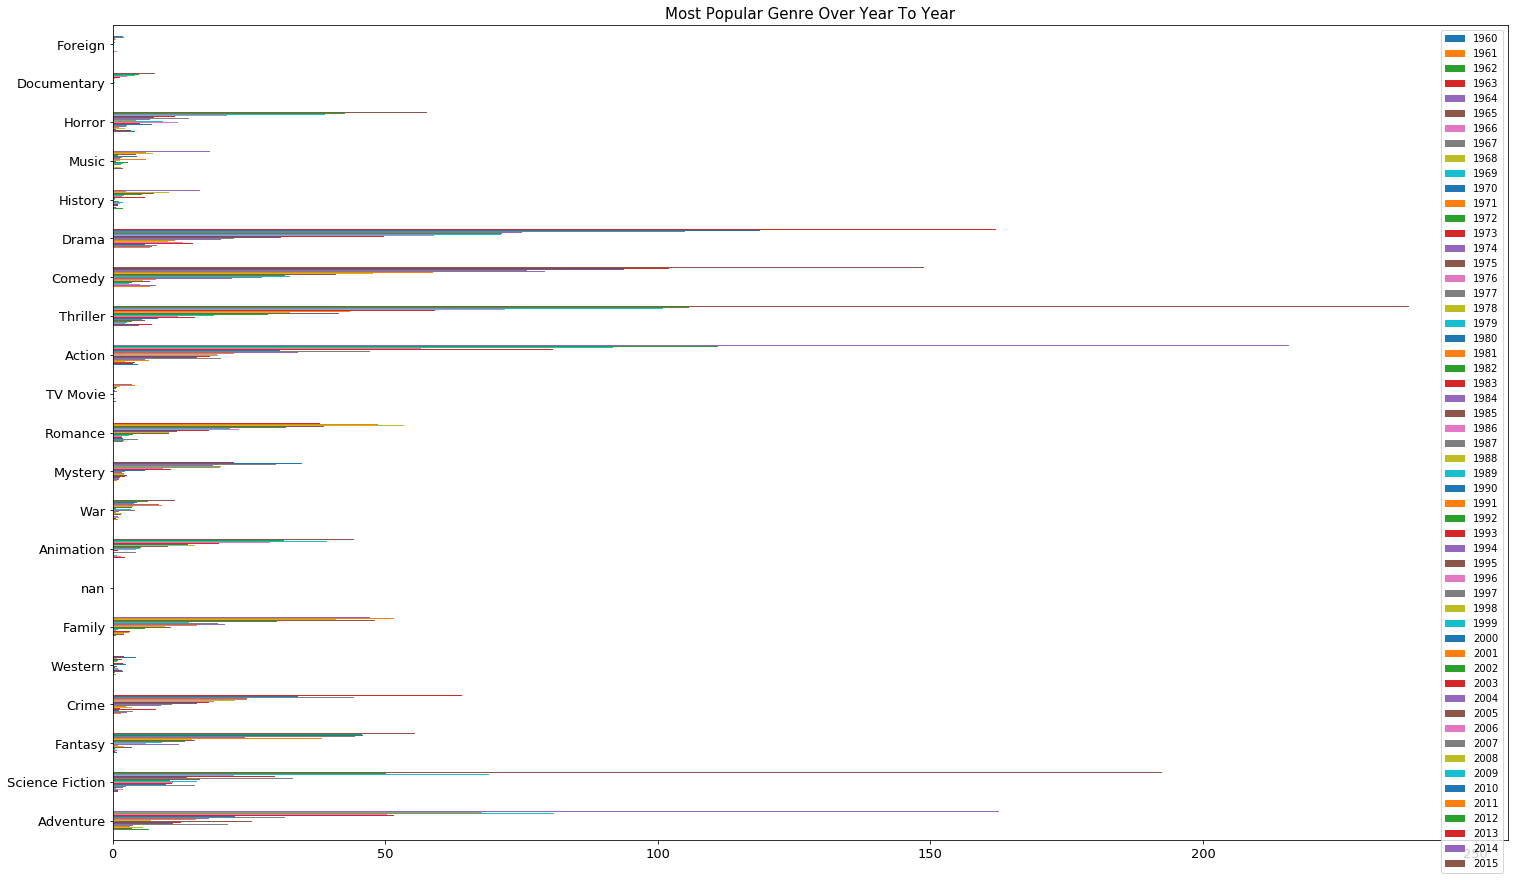

In [32]:
#plot each genre for each year
popularity_df.plot(kind='barh' ,figsize = (25,15),fontsize=13)
plt.title("Most Popular Genre Over Year To Year",fontsize=15)
sns.set_style("whitegrid")
plt.show

In [33]:
sns.set_style("whitegrid")

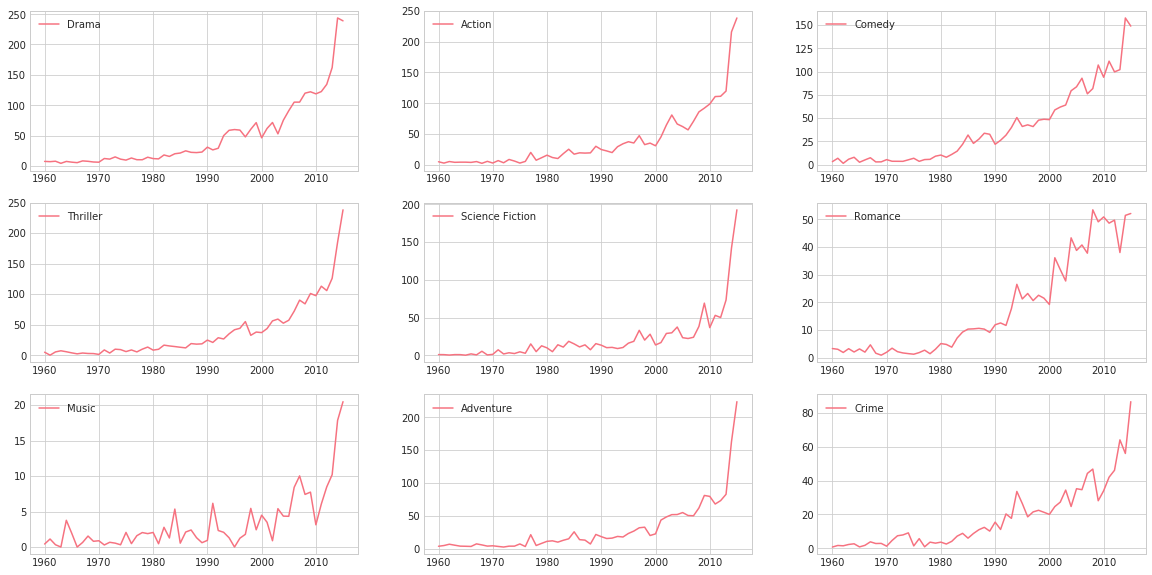

In [34]:
#plot each gerne over year to year to see the popularity diffrence between each them
fig , ax = plt.subplots(3,3 ,figsize = (20,10))
popularity_df.loc['Drama'].plot(label="Drama" , color ='#f67280' , ax = ax[0][0] , legend=True)
popularity_df.loc['Action'].plot(label="Action" , color ='#f67280' , ax = ax[0][1] , legend=True)
popularity_df.loc['Comedy'].plot(label="Comedy" , color ='#f67280' , ax = ax[0][2] , legend=True)
popularity_df.loc['Thriller'].plot(label="Thriller" , color ='#f67280' , ax = ax[1][0] , legend=True)
popularity_df.loc['Science Fiction'].plot(label="Science Fiction" , color ='#f67280' , ax = ax[1][1] , legend=True)
popularity_df.loc['Romance'].plot(label="Romance" , color ='#f67280' , ax = ax[1][2] , legend=True)
popularity_df.loc['Music'].plot(label="Music" , color ='#f67280' , ax = ax[2][0] , legend=True)
popularity_df.loc['Adventure'].plot(label="Adventure" , color ='#f67280' , ax = ax[2][1] , legend=True)
popularity_df.loc['Crime'].plot(label="Crime" , color ='#f67280' , ax = ax[2][2] , legend=True)

What kinds of properties are associated with movies that have high revenues?


In [35]:
#sort revenu column from high to low in data frame 
revenu_data = pd.DataFrame(df['revenue'].sort_values(ascending=False))
revenu_data

,revenue
1386,2781505847
3,2068178225
5231,1845034188
4361,1519557910
0,1513528810
4,1506249360
14,1405035767
3374,1327817822
5422,1274219009
5425,1215439994


In [36]:
#creat dataset for properties which i need
data_set = ['id','popularity','budget','original_title','cast','director','runtime','genres','vote_average','release_year']

In [37]:
#fill dataset with values
for i in data_set:
    revenu_data[i] = df[i]

In [38]:
revenu_data.head()

,revenue,id,popularity,budget,original_title,cast,director,runtime,genres,vote_average,release_year
1386,2781505847,19995,9.432768,237000000,Avatar,Sam Worthington|Zoe Saldana|Sigourney Weaver|S...,James Cameron,162,Action|Adventure|Fantasy|Science Fiction,7.1,2009
3,2068178225,140607,11.173104,200000000,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,7.5,2015
5231,1845034188,597,4.355219,200000000,Titanic,Kate Winslet|Leonardo DiCaprio|Frances Fisher|...,James Cameron,194,Drama|Romance|Thriller,7.3,1997
4361,1519557910,24428,7.637767,220000000,The Avengers,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,Joss Whedon,143,Science Fiction|Action|Adventure,7.3,2012
0,1513528810,135397,32.985763,150000000,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,6.5,2015


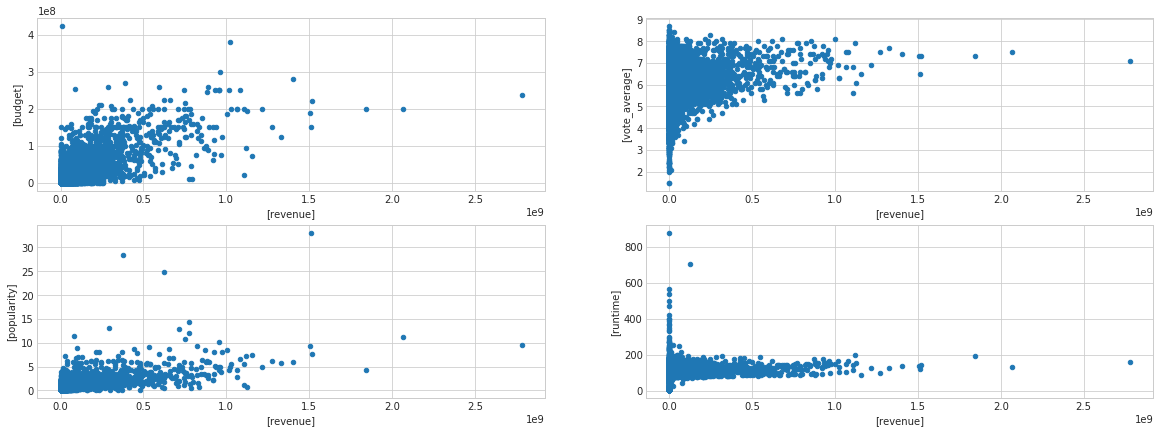

In [39]:
#plot scatter to show revenue vs each properity
fig , axes = plt.subplots(2,2,figsize =(20,7))
revenu_data.plot(x = ['revenue'],y = ['budget'],kind = "scatter",ax = axes[0][0])
revenu_data.plot(x = ['revenue'],y = ['vote_average'],kind = "scatter",ax = axes[0][1])
revenu_data.plot(x = ['revenue'],y = ['popularity'],kind = "scatter",ax = axes[1][0])
revenu_data.plot(x = ['revenue'],y = ['runtime'],kind = "scatter",ax = axes[1][1])

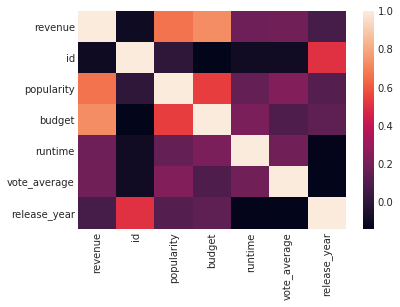

In [40]:
#using below function to show the correlation between each properity and revenue 
sns.heatmap(revenu_data.corr());

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed in relation to the question(s) provided at the beginning of the analysis. Summarize the results accurately, and point out where additional research can be done or where additional information could be useful.

> **Tip**: Make sure that you are clear with regards to the limitations of your exploration. You should have at least 1 limitation explained clearly. 

> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [41]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0